# Coffee Sales
This dataset contains information related to coffee sales, providing insights into various aspects of coffee products, sales performance, and customer preferences. It is designed to help analyze trends, optimize sales strategies, and understand the factors influencing coffee sales.

We start by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import warnings
warnings.filterwarnings("ignore")

we should load the data and have a overview of the data

In [ ]:
df1 = pd.read_csv('index_1.xls')
df2 = pd.read_csv('index_2.xls')

print(df1.head())
print(f'Rows: {df1.shape[0]}')
print(f'Columns: {df1.shape[1]}')

print('=' * 80)

print(df2.head())
print(f'Rows: {df2.shape[0]}')
print(f'Columns: {df2.shape[1]}')

         date                 datetime cash_type                 card  money  \
0  2024-03-01  2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   38.7   
1  2024-03-01  2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   38.7   
2  2024-03-01  2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   38.7   
3  2024-03-01  2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   28.9   
4  2024-03-01  2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   38.7   

     coffee_name  
0          Latte  
1  Hot Chocolate  
2  Hot Chocolate  
3      Americano  
4          Latte  
Rows: 3263
Columns: 6
         date             datetime cash_type  money            coffee_name
0  2025-02-08  2025-02-08 14:26:04      cash   15.0                    Tea
1  2025-02-08  2025-02-08 14:28:26      cash   15.0                    Tea
2  2025-02-08  2025-02-08 14:33:04      card   20.0               Espresso
3  2025-02-08  2025-02-08 15:51:04      card   30.0  Chocolate with coffee
4  2025-

- We can see that the second data frame hasn't the Card column and more than 90% of samples are in the first data frame

we concatenate these two datasets

In [ ]:
df = pd.concat([df1, df2], axis=0).reset_index(drop=True)
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte
...,...,...,...,...,...,...
3368,2025-02-24,2025-02-24 18:32:28,card,NaN,28.0,Caramel with Irish whiskey
3369,2025-02-24,2025-02-24 18:33:49,card,NaN,28.0,Caramel with Irish whiskey
3370,2025-02-24,2025-02-24 20:15:01,card,NaN,25.0,Caramel with milk
3371,2025-02-25,2025-02-25 21:41:58,card,NaN,29.0,Coffee with Irish whiskey


- keeping in mind that Card column has NaN values which should be handled

let's see what kind of data types we have

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3373 non-null   object 
 1   datetime     3373 non-null   object 
 2   cash_type    3373 non-null   object 
 3   card         3174 non-null   object 
 4   money        3373 non-null   float64
 5   coffee_name  3373 non-null   object 
dtypes: float64(1), object(5)
memory usage: 158.2+ KB


In [ ]:
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
card,199
money,0
coffee_name,0


In [ ]:
df.duplicated().sum()

0

- it's look like except for the Card column we don't have any missing values
- we should handle date and datetime features which their type are time series

Here we convert date and datetime features to Time, Month and Week features

In [ ]:
# Converting datetime and date column's types to datetime objects
df["datetime"] = pd.to_datetime(df["datetime"], format="mixed")
df["date"] = pd.to_datetime(df["date"])

# Extarcting months, weeks, days of the week, and hours from date and datetime features
df["month"] = df["date"].dt.to_period("M")
df["week"] = df["date"].dt.to_period("W")
df["day_of_week"] =df["date"].dt.day_name() # dt.day_name-> gives categorical type(Object) dt.dayofweek -> gives integer of days
df["hour"] = df["datetime"].dt.hour

In [ ]:
df.head()

,date,datetime,cash_type,card,money,coffee_name,month,week,day_of_week,hour
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024-03,2024-02-26/2024-03-03,Friday,10
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03,2024-02-26/2024-03-03,Friday,12
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03,2024-02-26/2024-03-03,Friday,12
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024-03,2024-02-26/2024-03-03,Friday,13
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024-03,2024-02-26/2024-03-03,Friday,13


here we get descriptive statistics understanding of Money which is a numerical continuous column

In [ ]:
df.describe()[['money']]

,money
count,3373.000000
mean,31.620546
min,15.000000
25%,27.920000
50%,32.820000
75%,35.760000
max,40.000000
std,5.023208


- It doesn't look like we have too much outliers in money column because the average have nearly same distance between minimum and maximum

Let's calculatethe total money which all customers paid for coffee to this coffee shop

In [ ]:
print(f"Total Money: {round(df['money'].sum())}")

Total Money: 106656


Get to know how much of this total money comes from payment by card and by cash

In [ ]:
card_money_sum = round(df[df.cash_type == 'card']['money'].sum())
print(f"{card_money_sum}$ of total money comes from payment by card")

print('-' * 50)

cash_money_sum = round(df[df.cash_type == 'cash']['money'].sum())
print(f"{cash_money_sum}$ of total money comes from payment by cash")

102528$ of total money comes from payment by card
--------------------------------------------------
4128$ of total money comes from payment by cash


- most of payments are by card

Calculating the average money customers paid in each cash type

In [ ]:
avg_sales_by_payment = round(df.groupby("cash_type")['money'].mean())
print(avg_sales_by_payment)

cash_type
card    32.0
cash    33.0
Name: money, dtype: float64


- No significant difference

Making sure that people rather to pay in cash or by card

In [ ]:
df.cash_type.value_counts()

,count
cash_type,
card,3246
cash,127


- we can see that people prefer paying by card

Take a look at coffee_name column

In [ ]:
df.describe(include='object').iloc[:,2]

,coffee_name
count,3373
unique,27
top,Americano with Milk
freq,764


- we can see that we have 27 coffee names -> challenge with encoding
- Americano with Milk was popular among other coffees

Let's see what coffees are popular

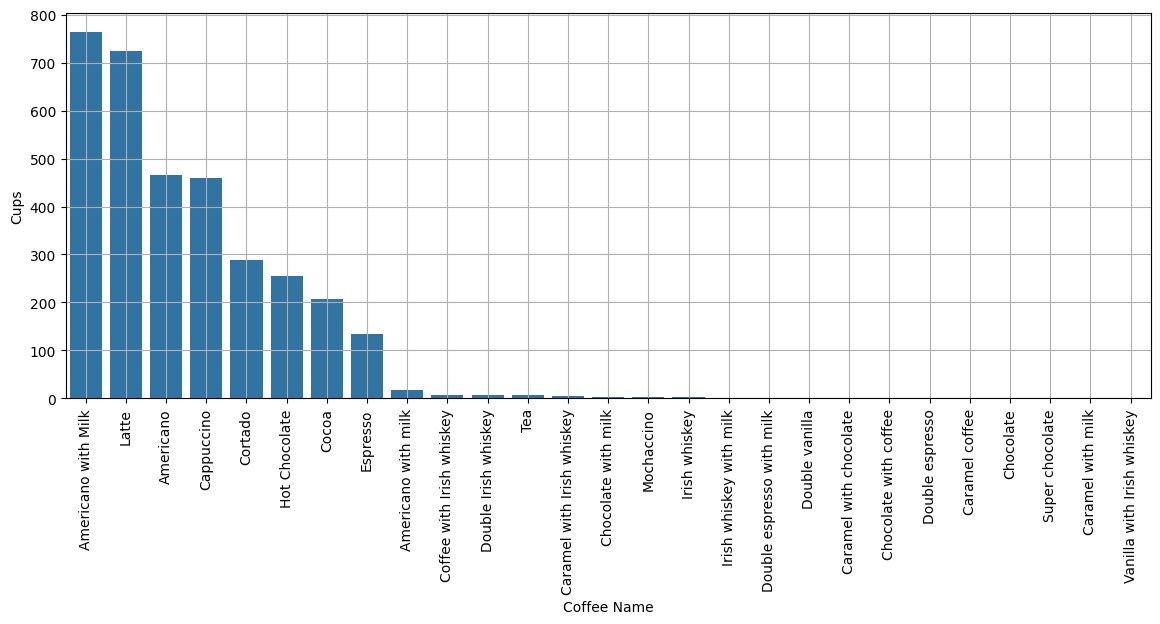

In [ ]:
coffee_name_df = df.groupby("coffee_name").agg({"money" : "count"}).reset_index()
coffee_name_df.columns = ["Coffee Name", "Cups"]
coffee_name_df.sort_values(by="Cups", ascending=False, inplace=True)

plt.figure(figsize=(14,5))
sns.barplot(data=coffee_name_df, x="Coffee Name", y="Cups")
plt.xticks(rotation=90)
plt.grid()

Here we show on chart in each month how much money we got from selling coffees

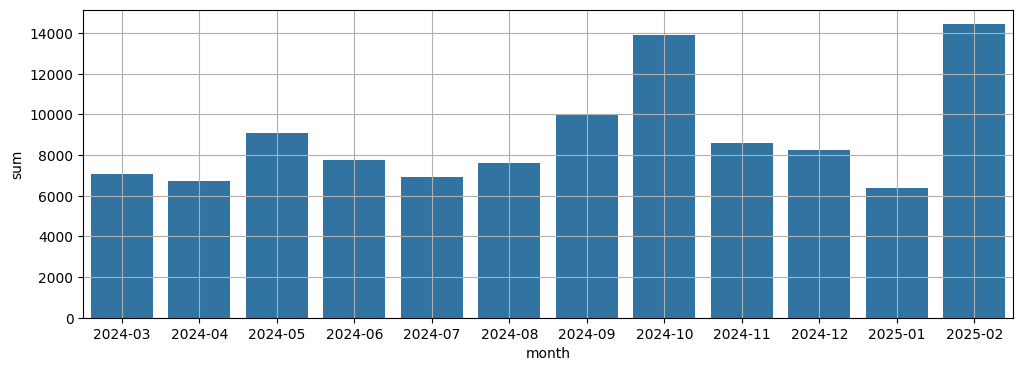

In [ ]:
month_df = df.groupby("month").agg({"money" : ["sum", "count", "mean"]}).reset_index()
month_df.columns = ["month", "sum", "cups", "Average"]

plt.figure(figsize=(12,4))
sns.barplot(data=month_df, x="month", y="sum")
plt.grid()

- We sold nearly 14000$ in 2024-10 and 2025-02 (Maximum)
- the minimum of our sales was in 2025-01 which is normal because of christmas

Now we narrow down the time intervals from months to weeks, days of the week and hours

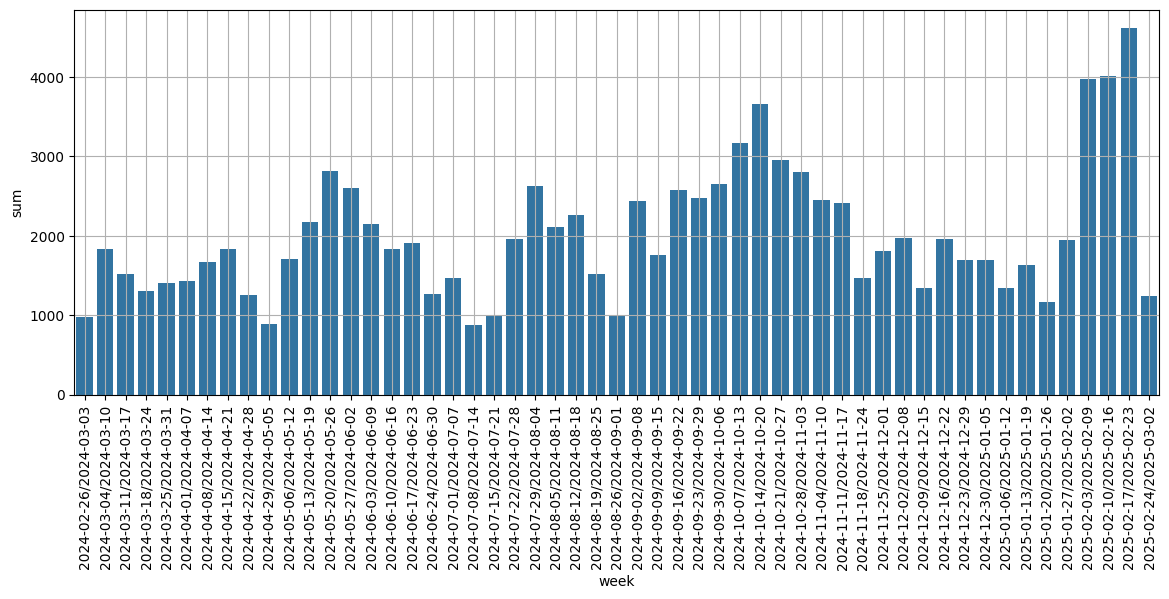

In [ ]:
week_df = df.groupby("week").agg({"money" : ["sum", "count"]}).reset_index()
week_df.columns = ["week", "sum", "cups"]

plt.figure(figsize=(14, 5))
sns.barplot(data=week_df, x="week", y="sum")
plt.xticks(rotation=90)
plt.grid()

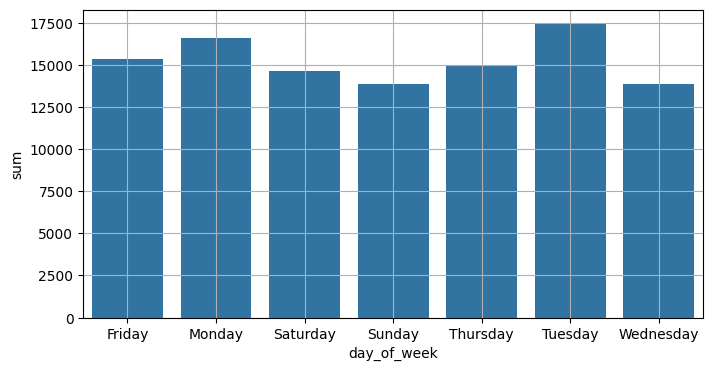

In [ ]:
day_of_week_df = df.groupby("day_of_week").agg({"money" : ["sum", "count"]}).reset_index()
day_of_week_df.columns = ["day_of_week", "sum", "cups"]

plt.figure(figsize=(8,4))
sns.barplot(data=day_of_week_df, x="day_of_week", y="sum")
plt.grid()

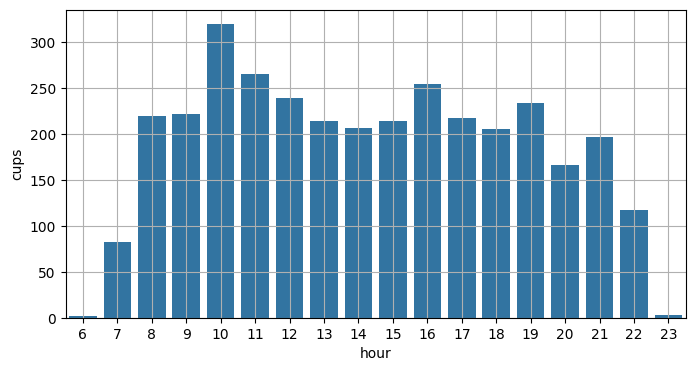

In [ ]:
hour_df = df.groupby("hour").agg({"money" : "count"}).reset_index()
hour_df.columns = ["hour", "cups"]

plt.figure(figsize=(8,4))
sns.barplot(data=hour_df, x="hour", y="cups")
plt.grid()

Now we should see the coffee sales over time

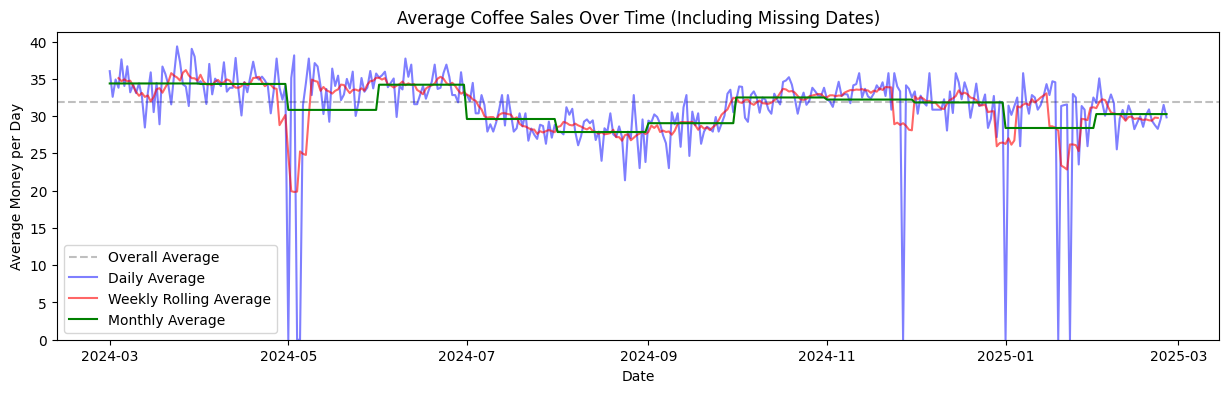

In [ ]:
# Set 'date' as the index and aggregate duplicates by mean
date_index_df = df.set_index("date")
date_index_df = date_index_df.groupby("date")["money"].mean().to_frame()

# Create a complete date range and fill missing sales with 0
date_range = pd.date_range(start=date_index_df.index.min(), end=date_index_df.index.max(), freq='D')
daily_avg = date_index_df["money"].reindex(date_range).fillna(0)  # Daily average

# Calculate averages
overall_avg = date_index_df["money"].mean()  # Overall average (ignores missing dates)
weekly_rolling_avg = daily_avg.rolling(window=7, center=True).mean()  # Weekly rolling average of daily averages

# Calculate monthly averages (average of daily averages)
temp_df = daily_avg.reset_index(name='daily_avg')
temp_df["month"] = temp_df["index"].dt.to_period("M")
monthly_money_avg = temp_df.groupby("month")["daily_avg"].mean().reset_index()
monthly_money_avg.columns = ["month", "avg_monthly_money"]

# Merge monthly averages back into daily data
monthly_avg = pd.merge(temp_df, monthly_money_avg, on="month", how="left")

# Plotting
plt.figure(figsize=(15, 4))
plt.axhline(overall_avg, color='gray', alpha=0.5, linestyle='--', label='Overall Average')
plt.plot(daily_avg.index, daily_avg, alpha=0.5, color='blue', label='Daily Average')
plt.plot(daily_avg.index, weekly_rolling_avg, alpha=0.6, color='red', label="Weekly Rolling Average")
plt.plot(monthly_avg["index"], monthly_avg["avg_monthly_money"], color="green", label="Monthly Average")
plt.xlabel('Date')
plt.ylabel('Average Money per Day')
plt.ylim(0)
plt.title('Average Coffee Sales Over Time (Including Missing Dates)')
plt.legend(loc='lower left')
plt.grid(False)
plt.show()

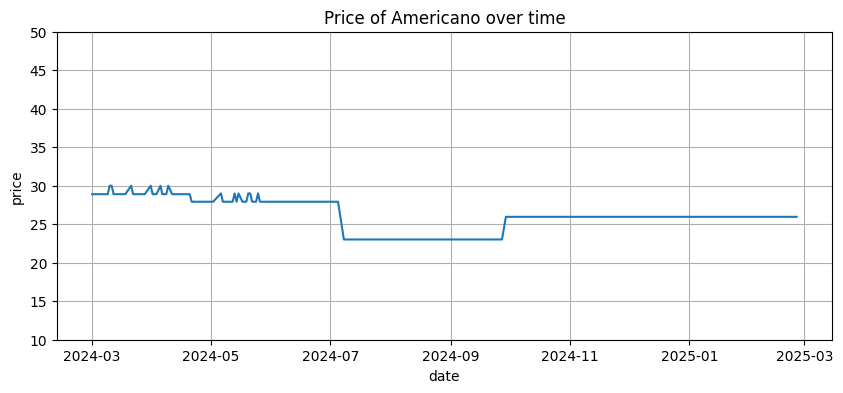

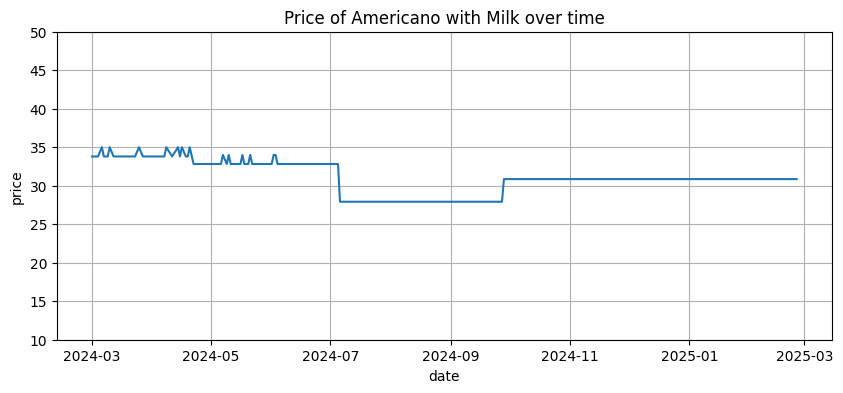

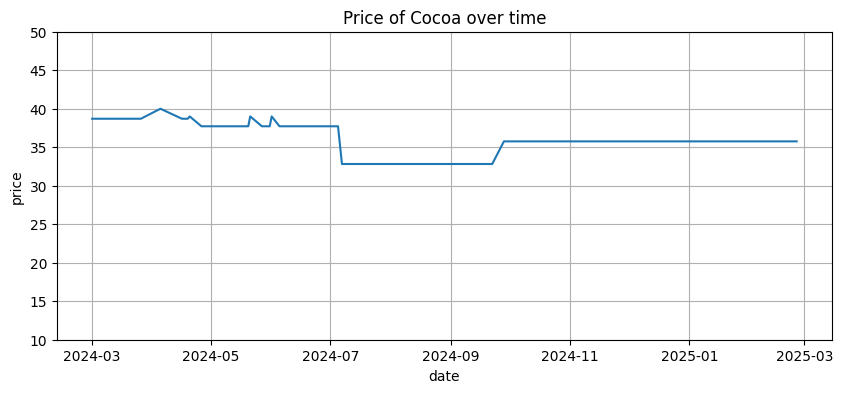

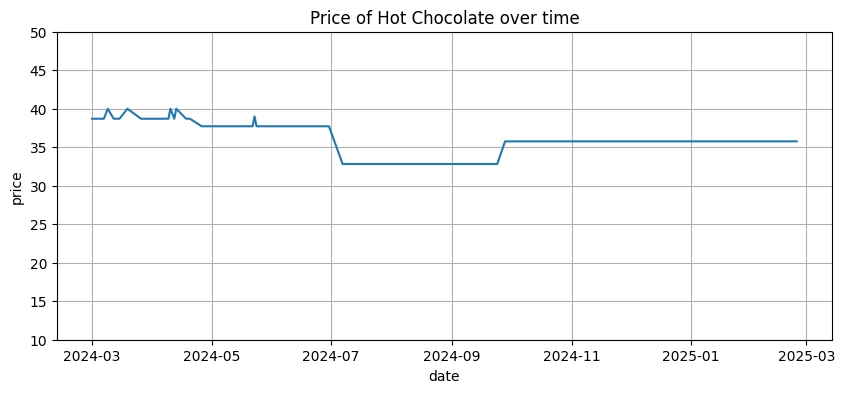

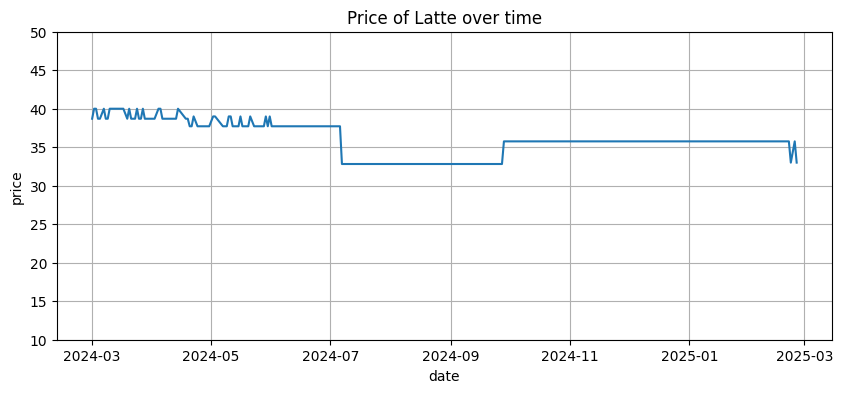

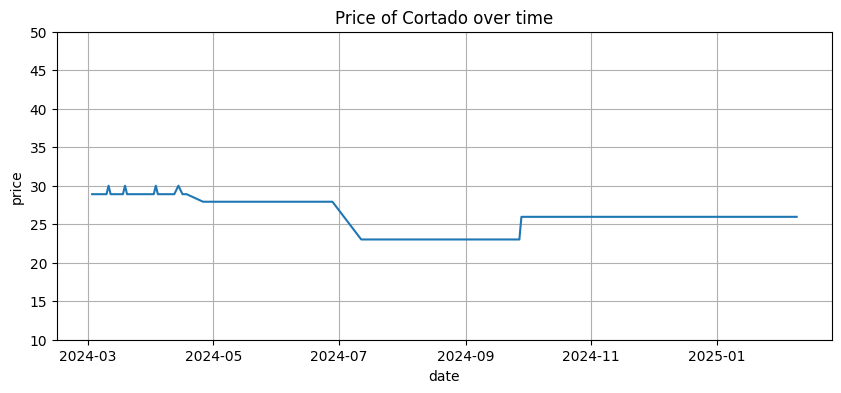

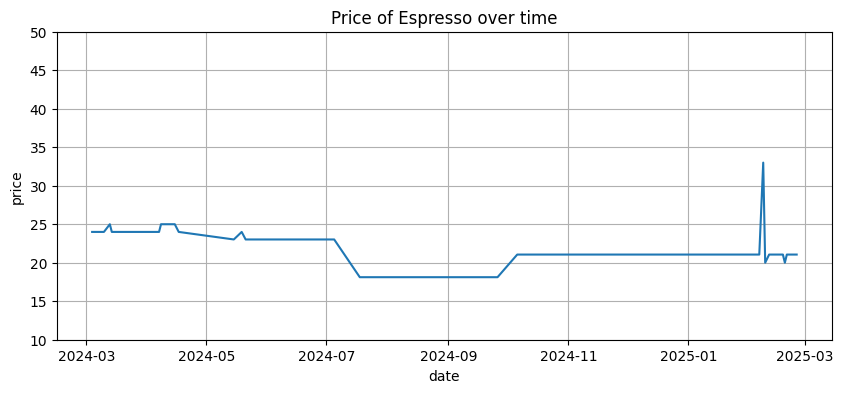

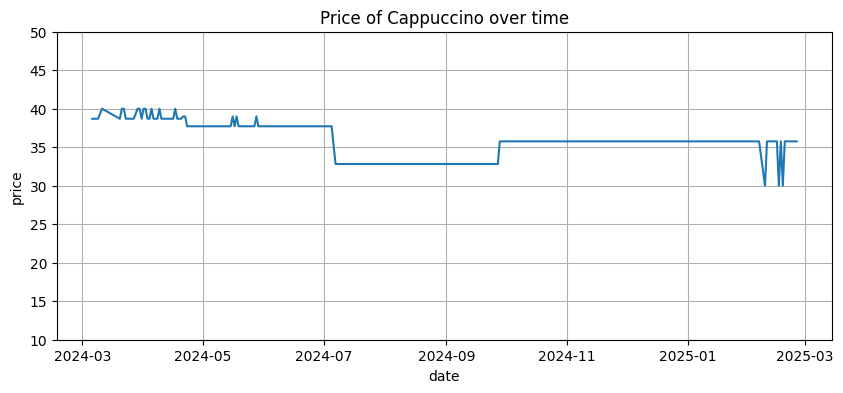

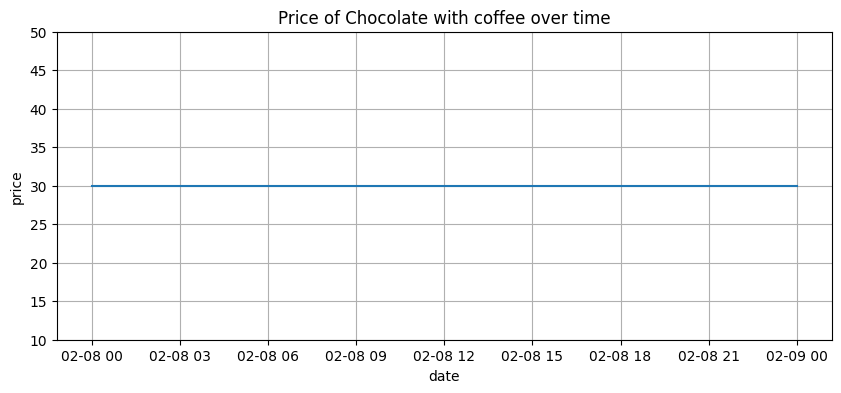

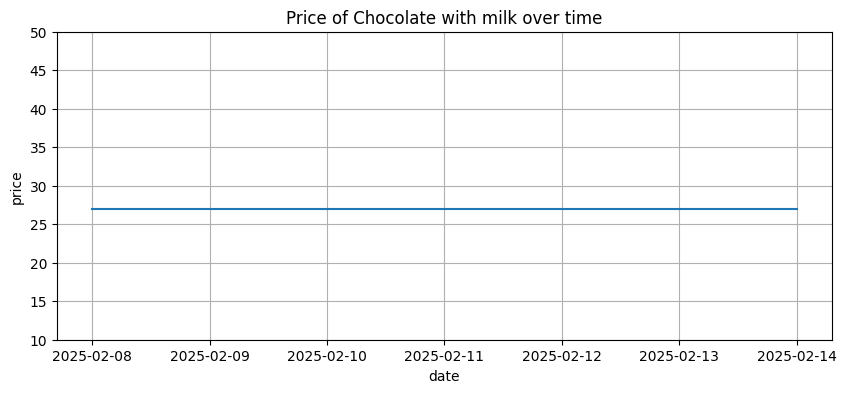

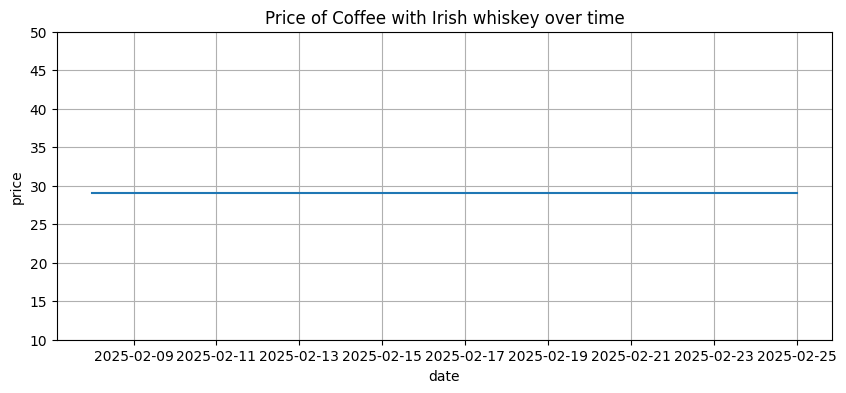

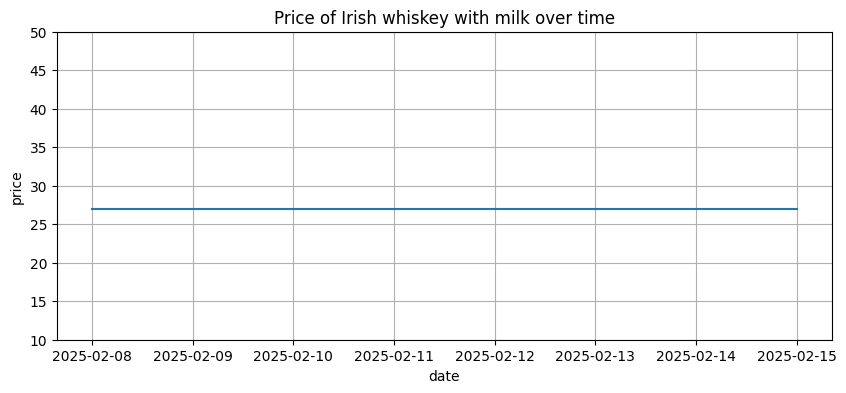

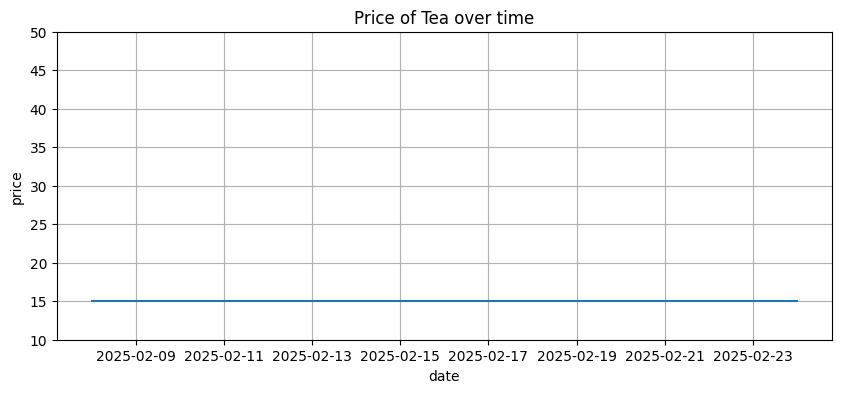

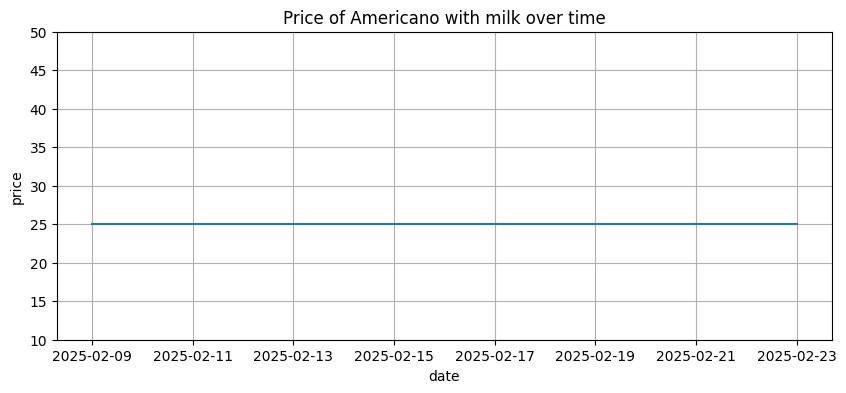

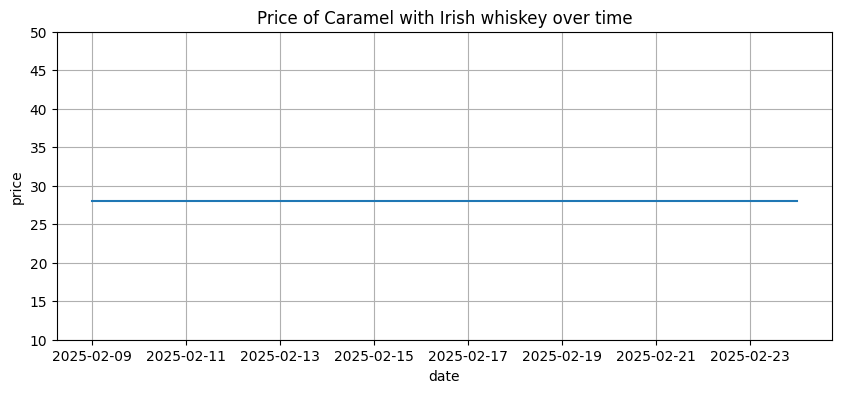

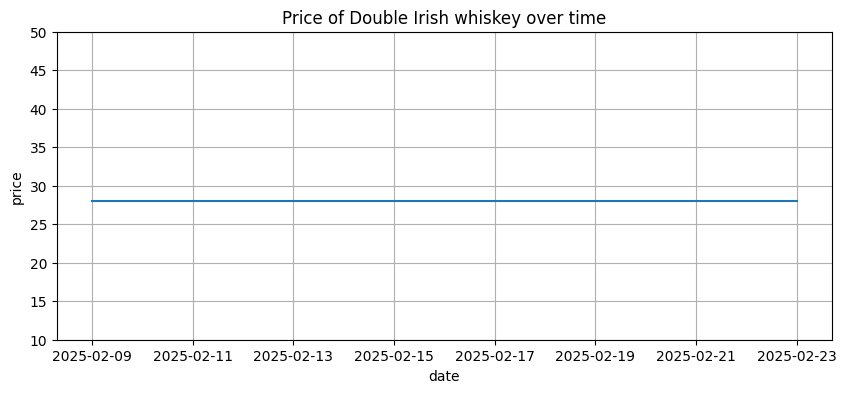

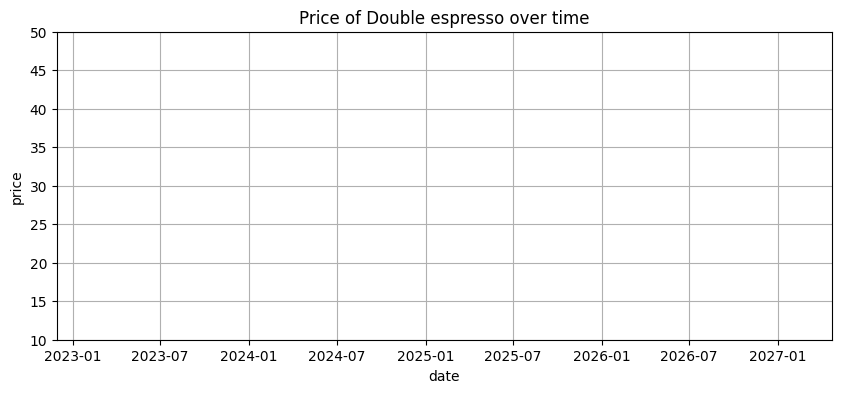

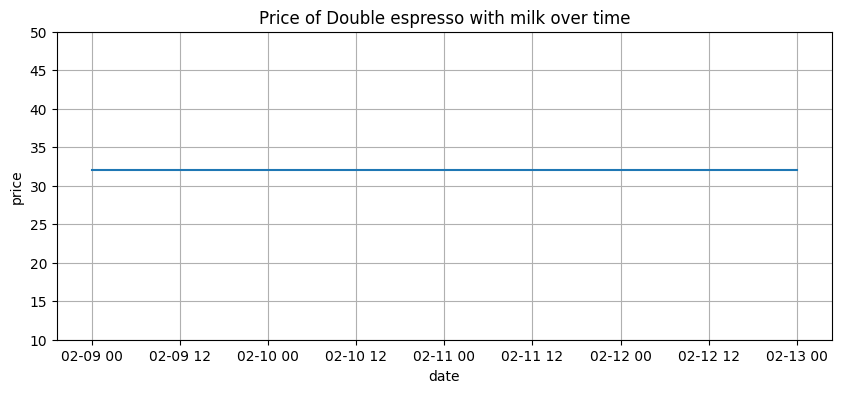

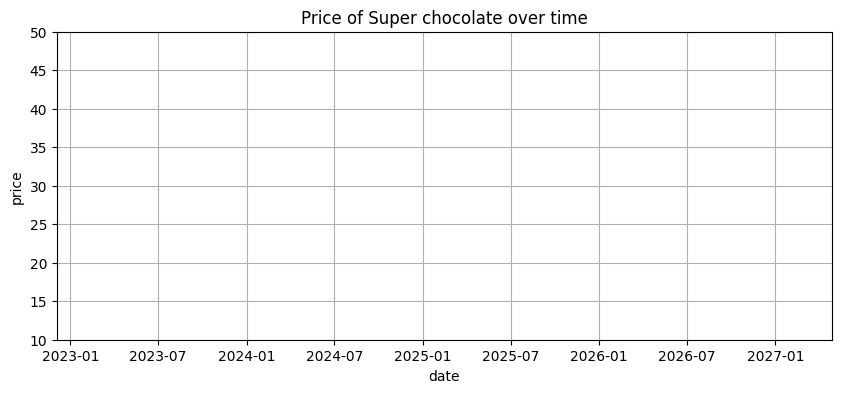

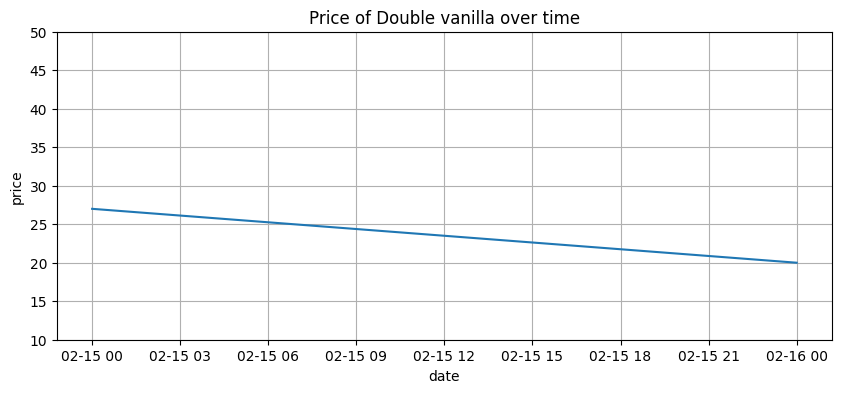

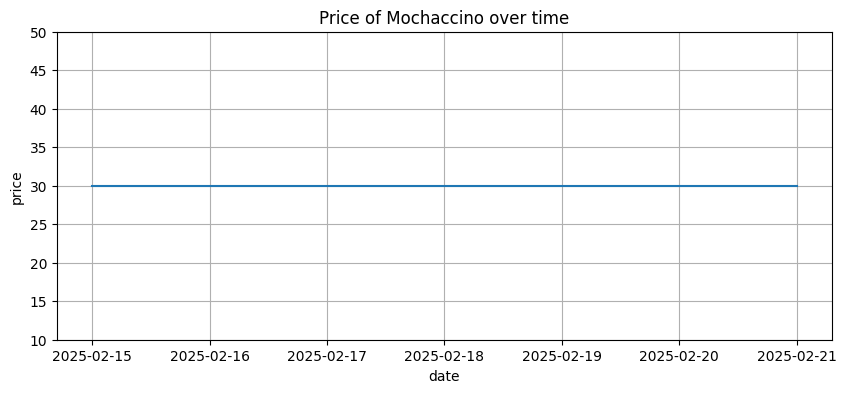

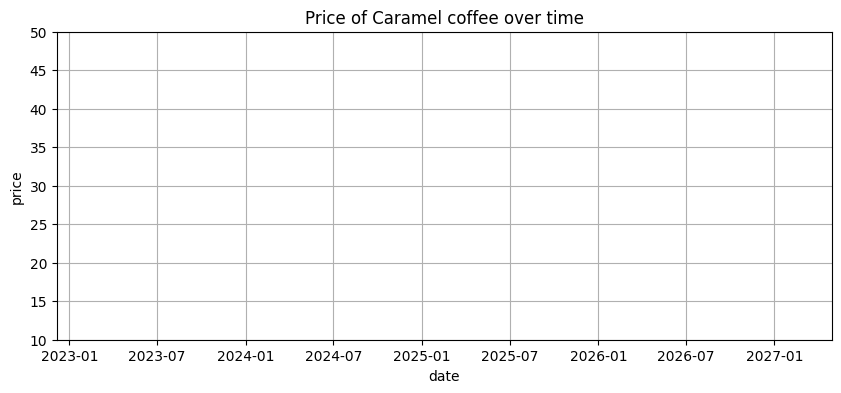

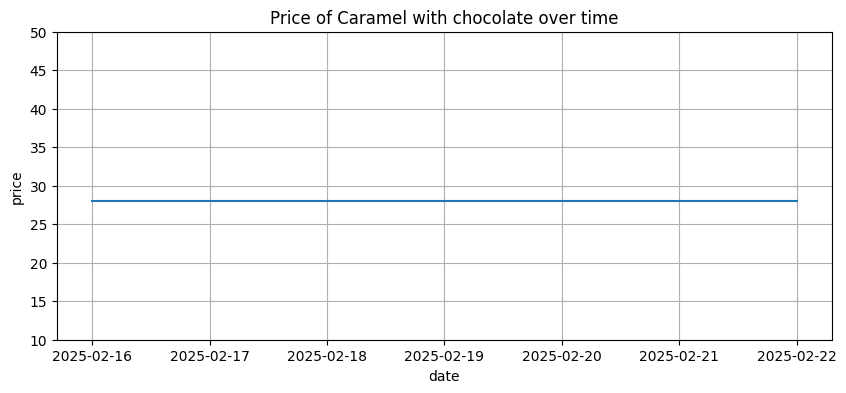

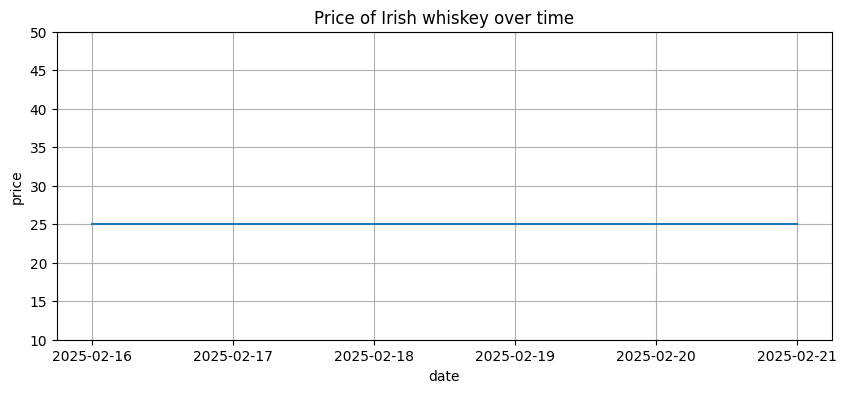

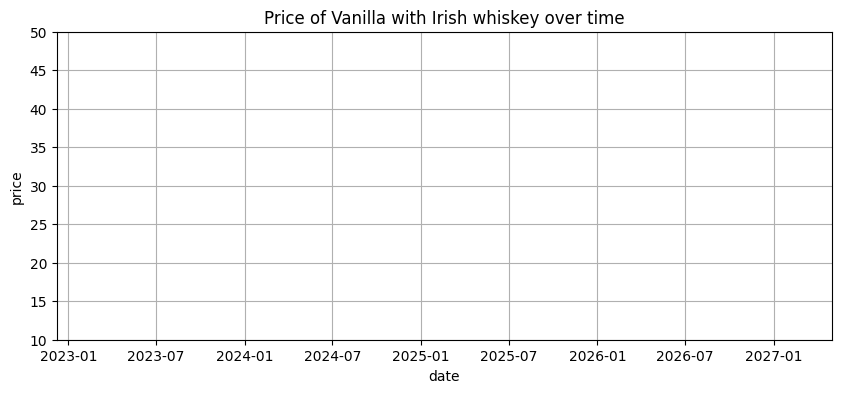

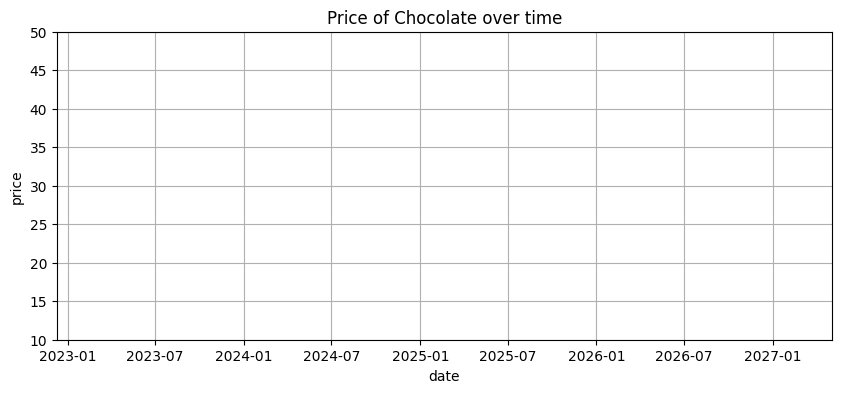

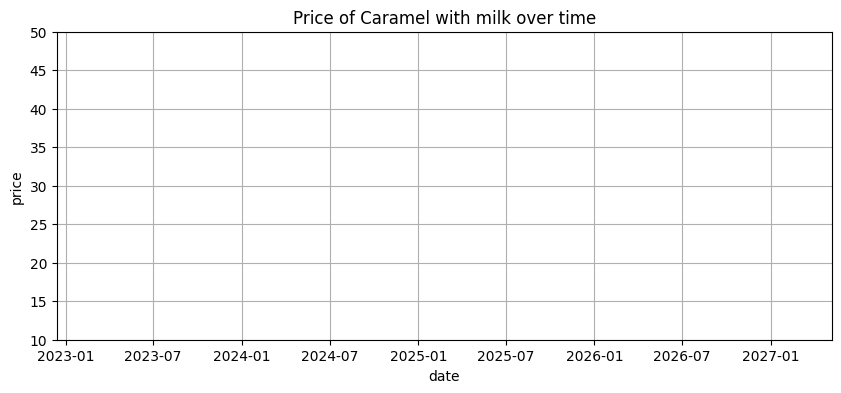

In [ ]:
df_by_date = df.groupby(["date", "coffee_name"]).agg({"money" : "max"}).reset_index()
df_by_date.columns = ["date", "coffee_name", "price"]

for coffee in df_by_date["coffee_name"].unique():
    plt.figure(figsize=(10,4))
    coffee_price = df_by_date[df_by_date["coffee_name"] == coffee]
    sns.lineplot(data=coffee_price, x="date", y="price")
    plt.title(f"Price of {coffee} over time")
    plt.ylim(10, 50)
    plt.grid()
    plt.show()

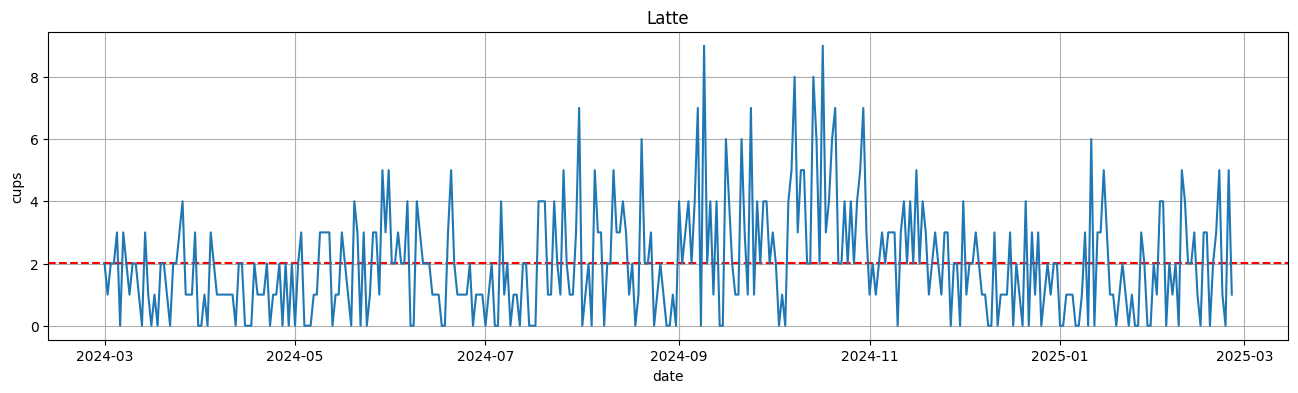

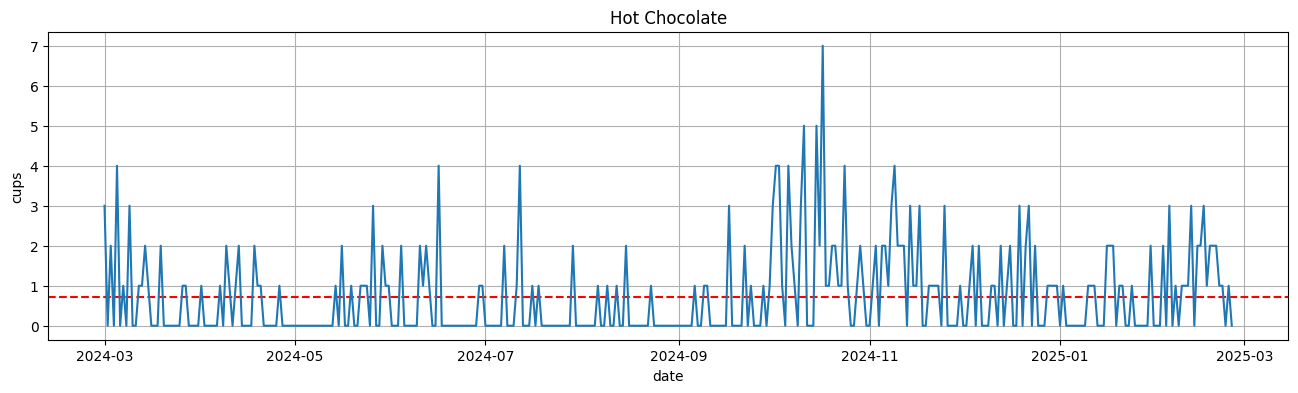

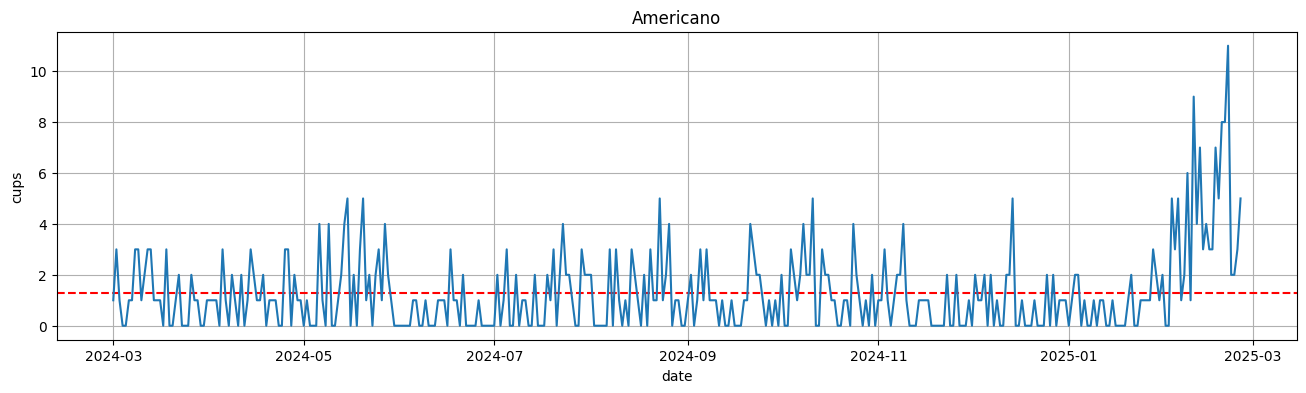

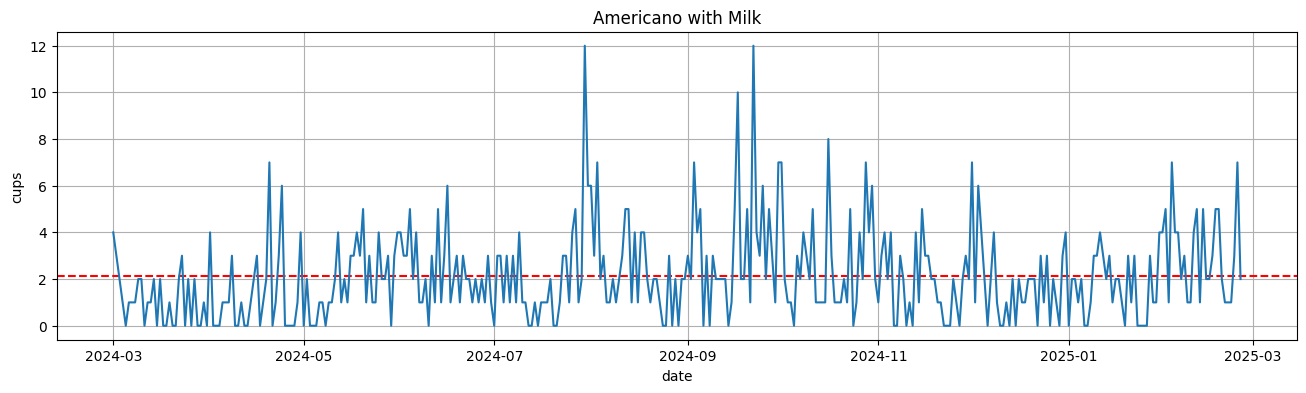

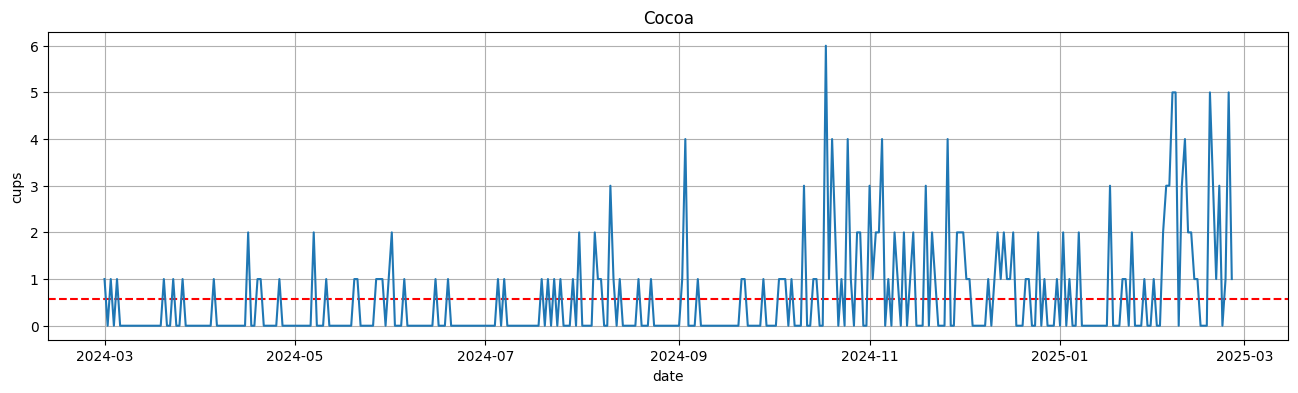

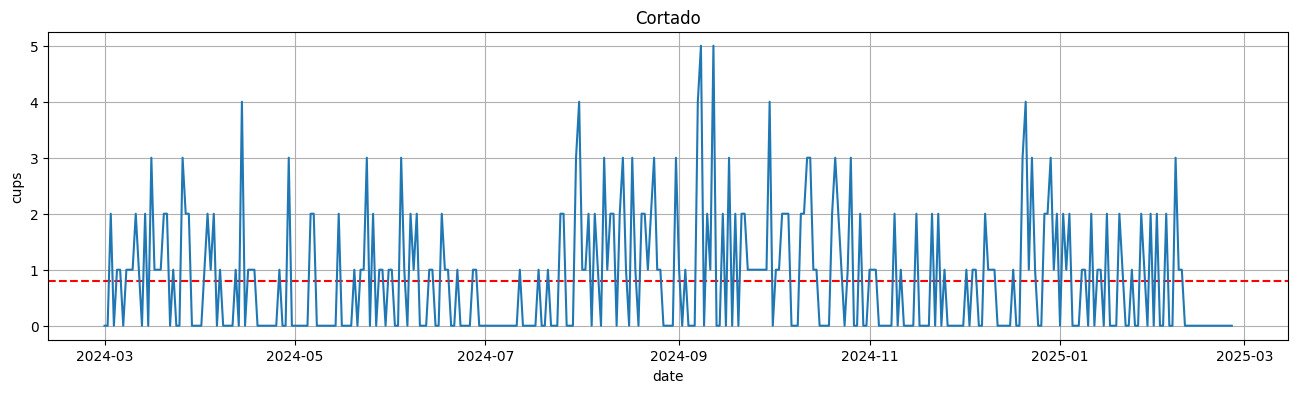

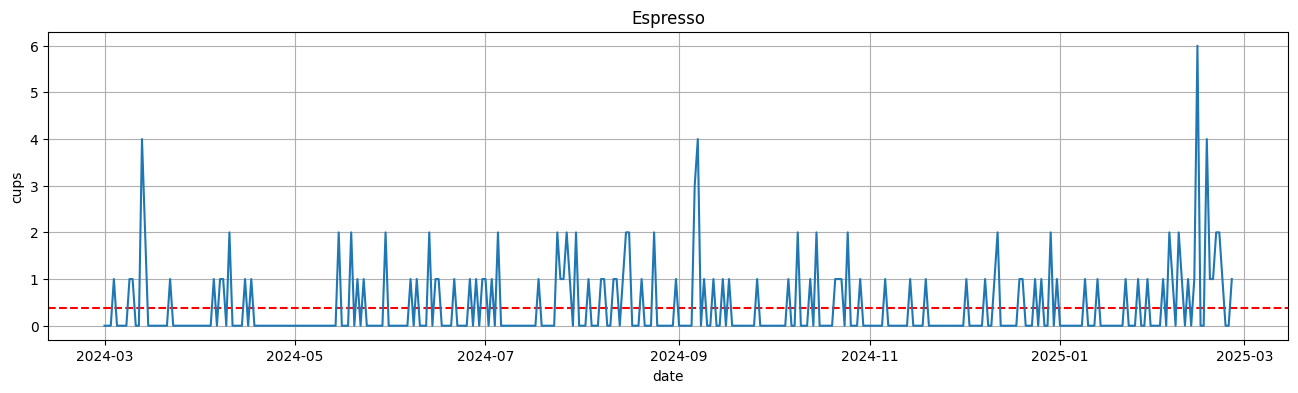

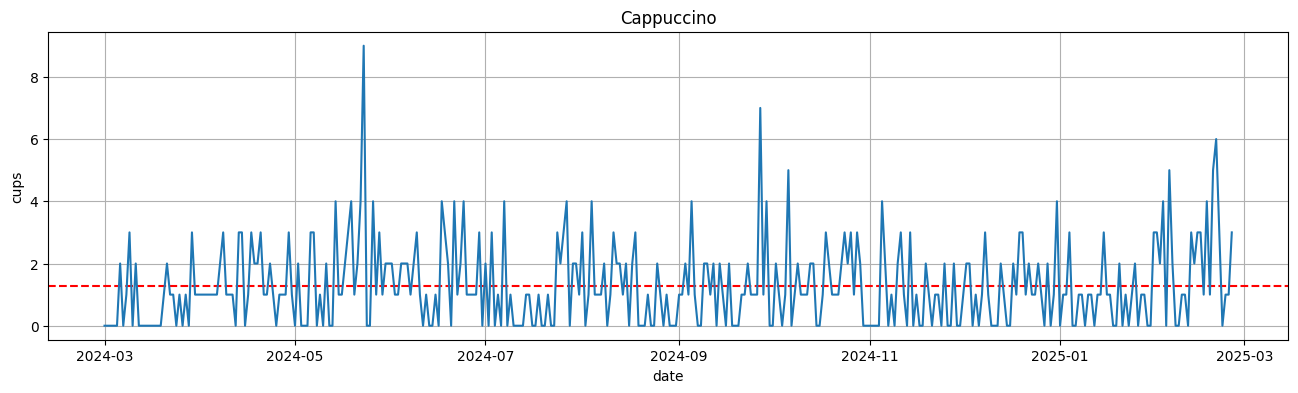

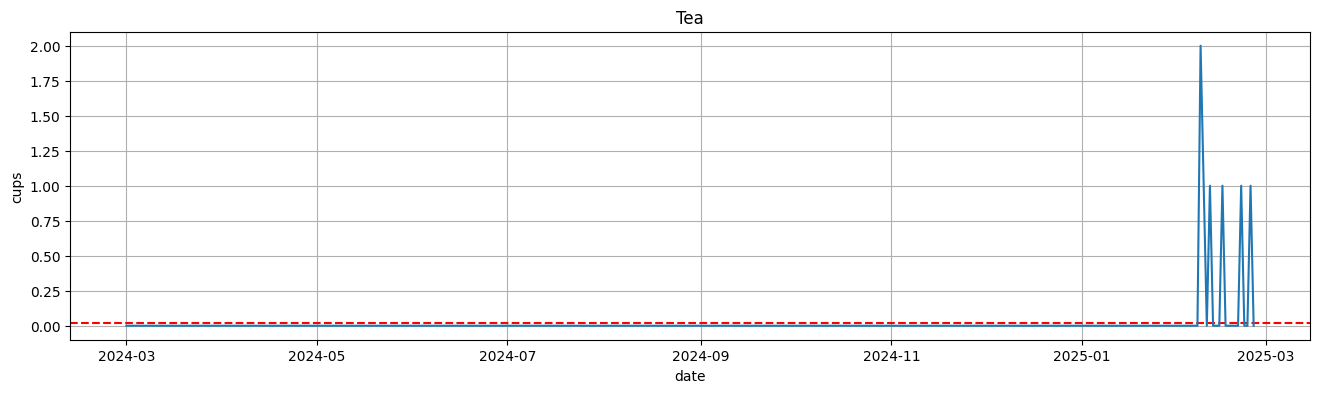

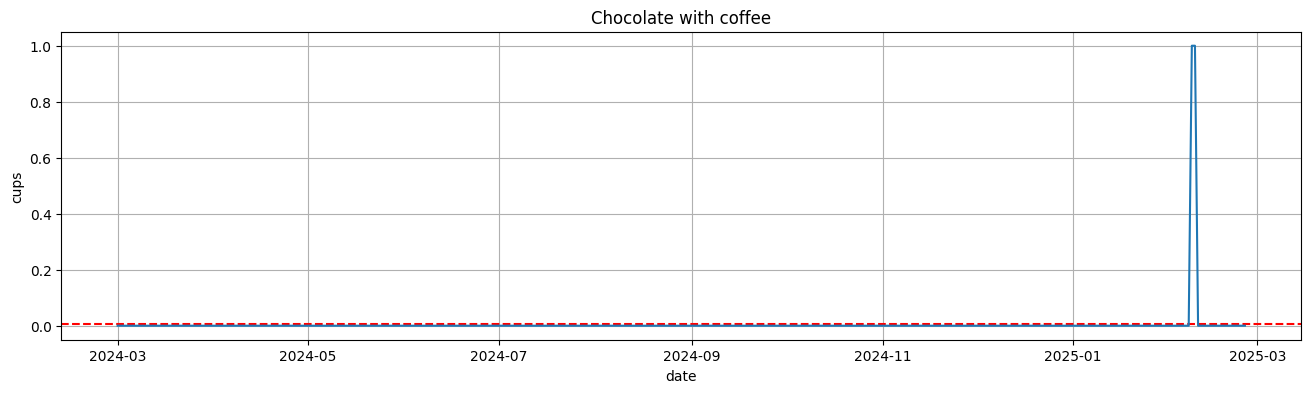

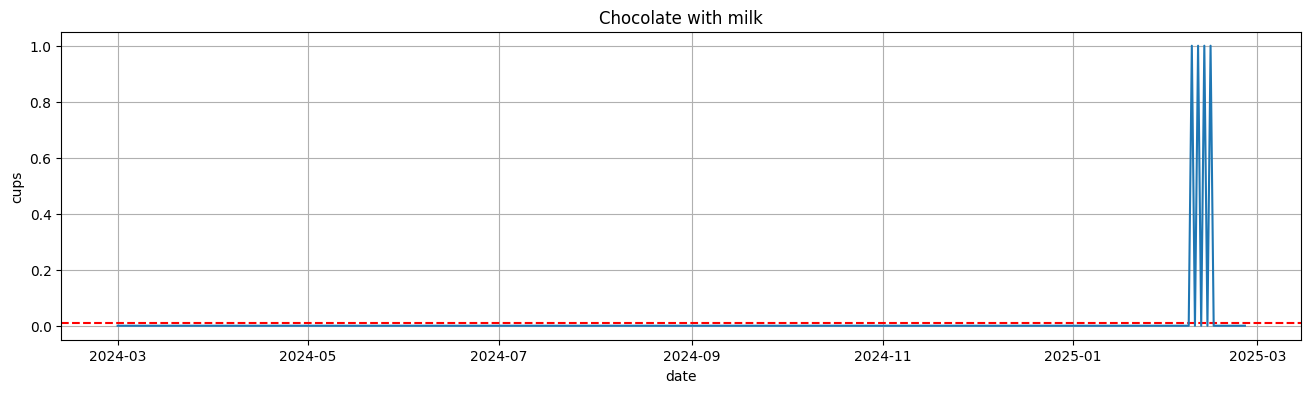

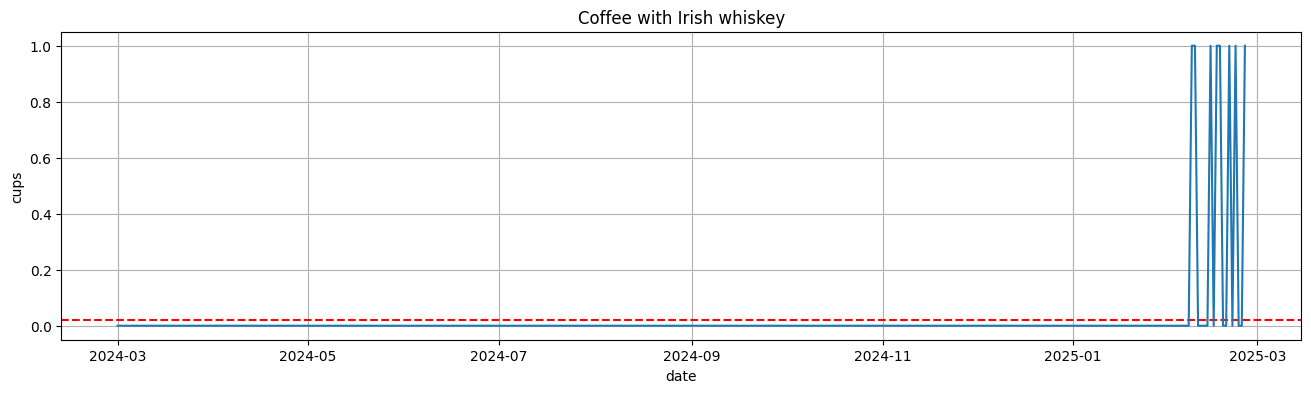

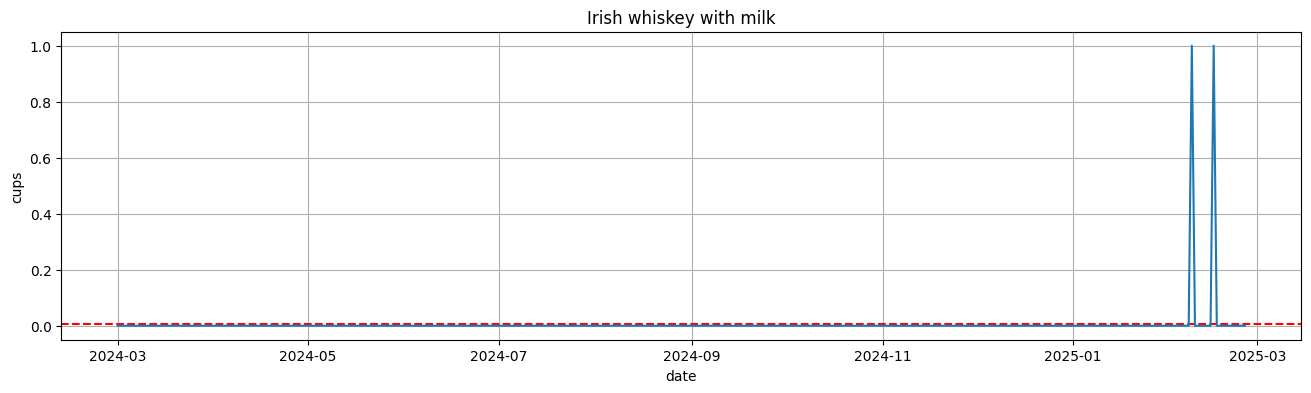

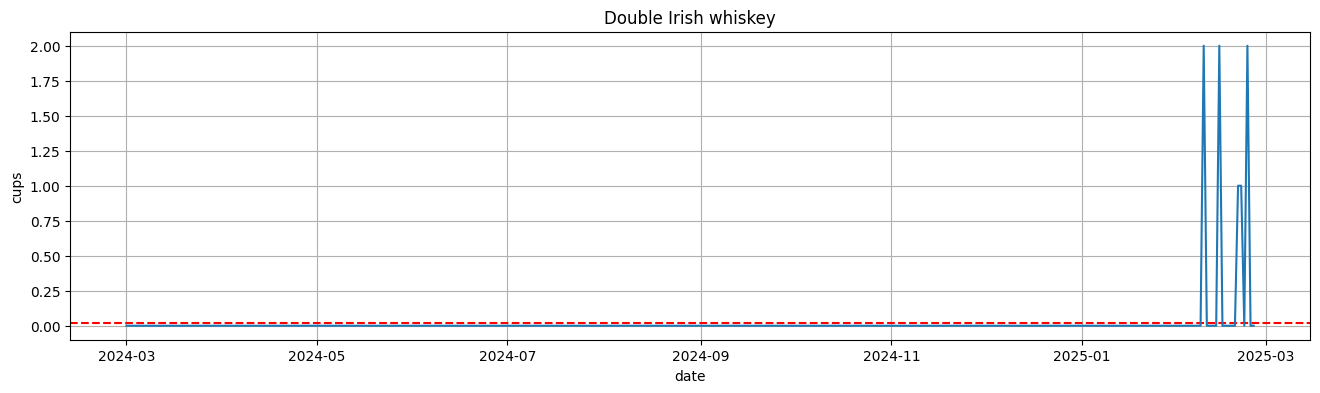

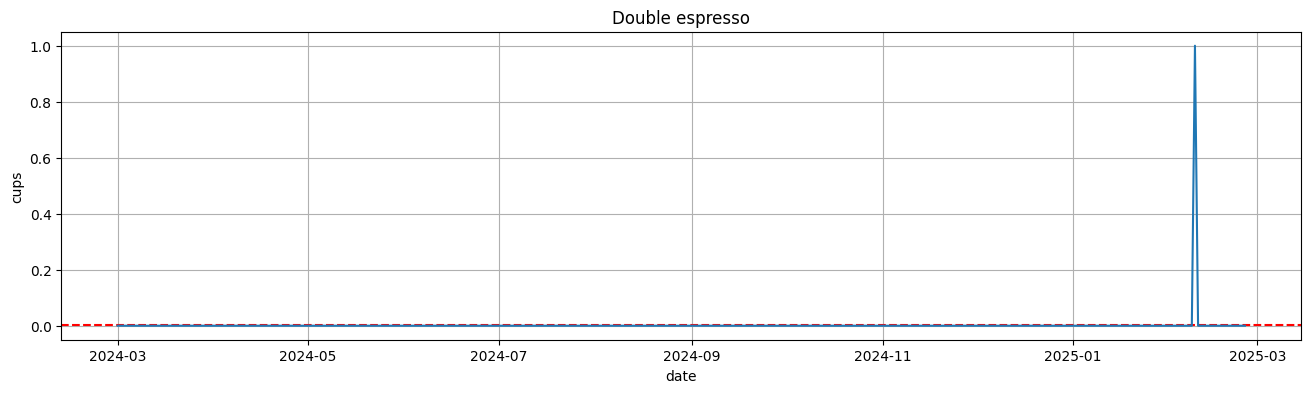

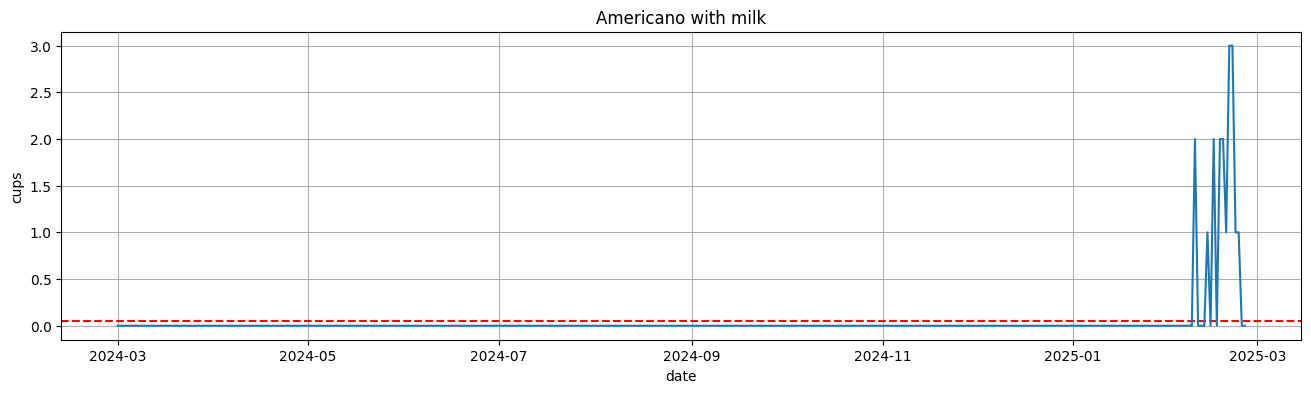

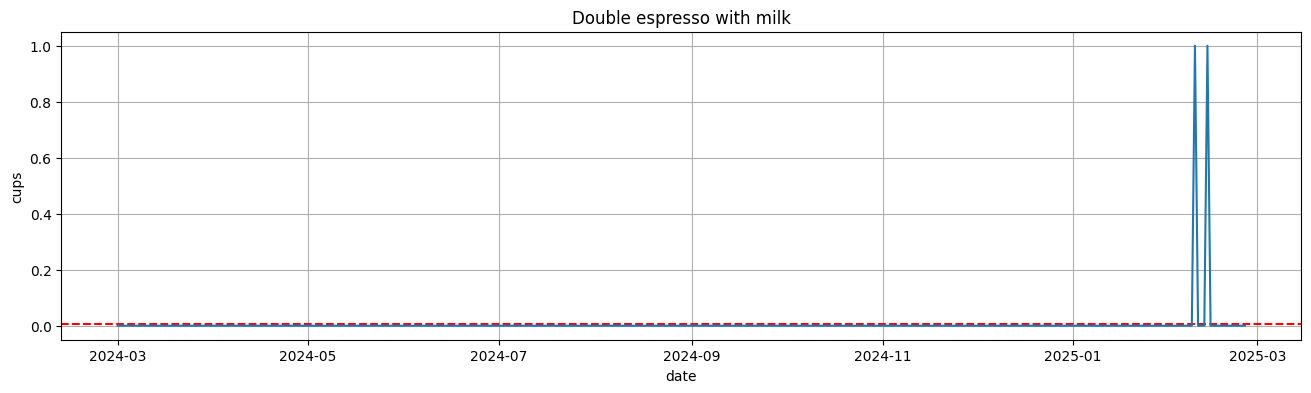

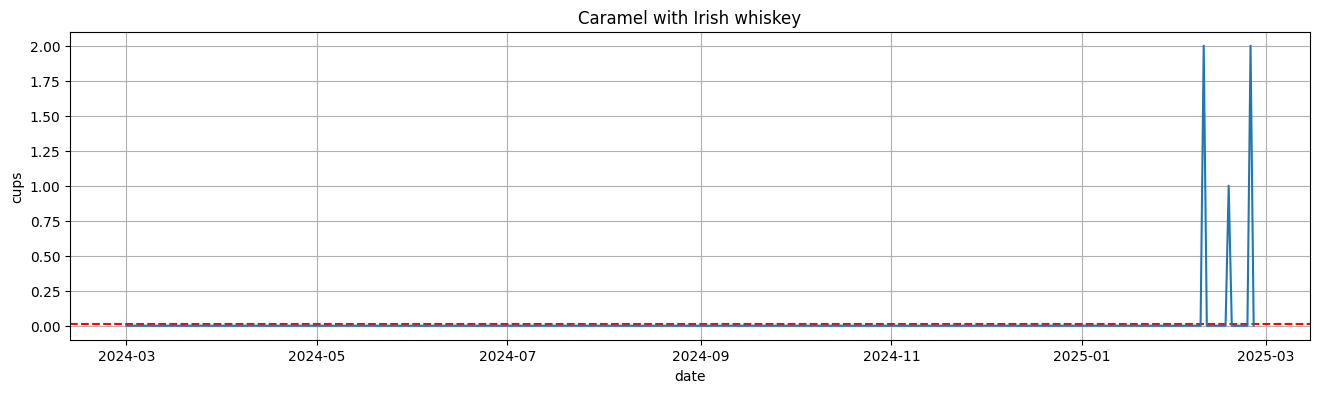

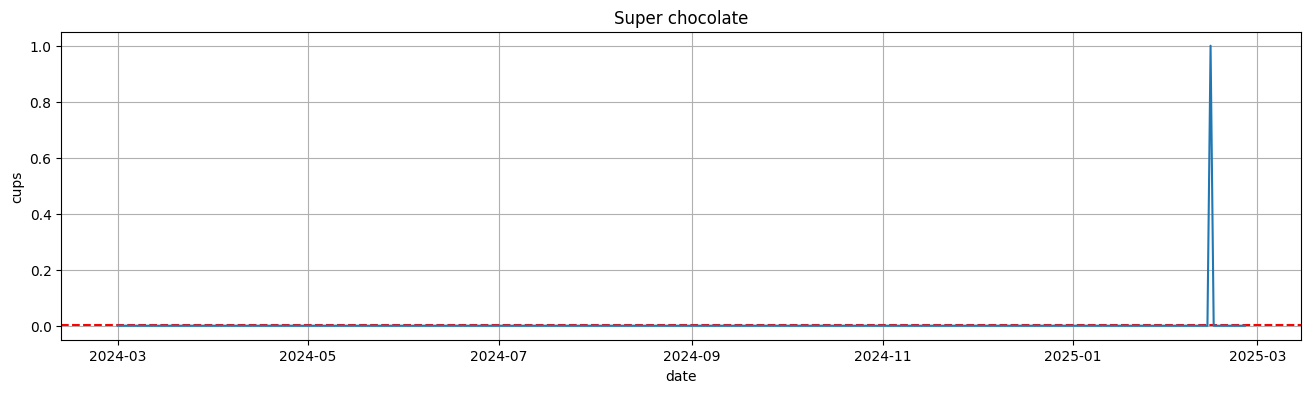

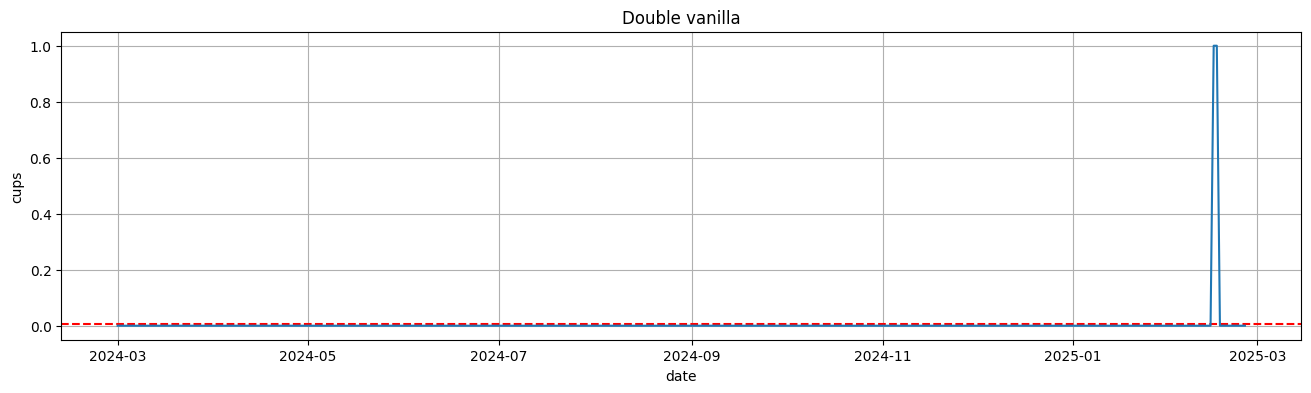

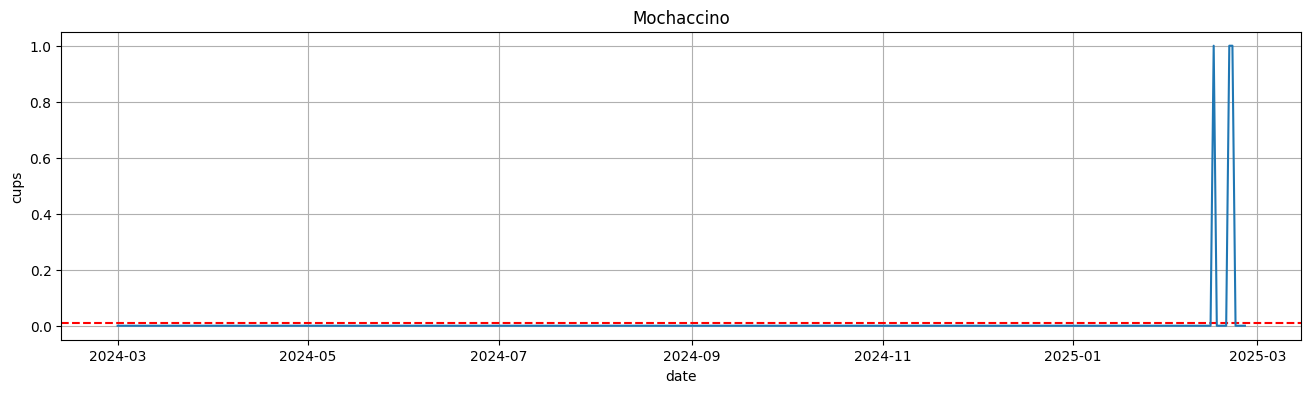

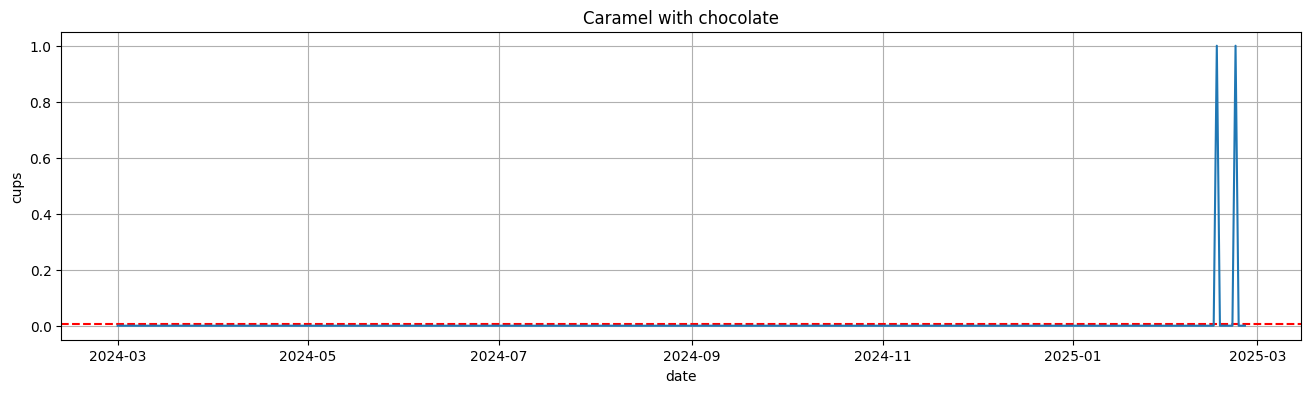

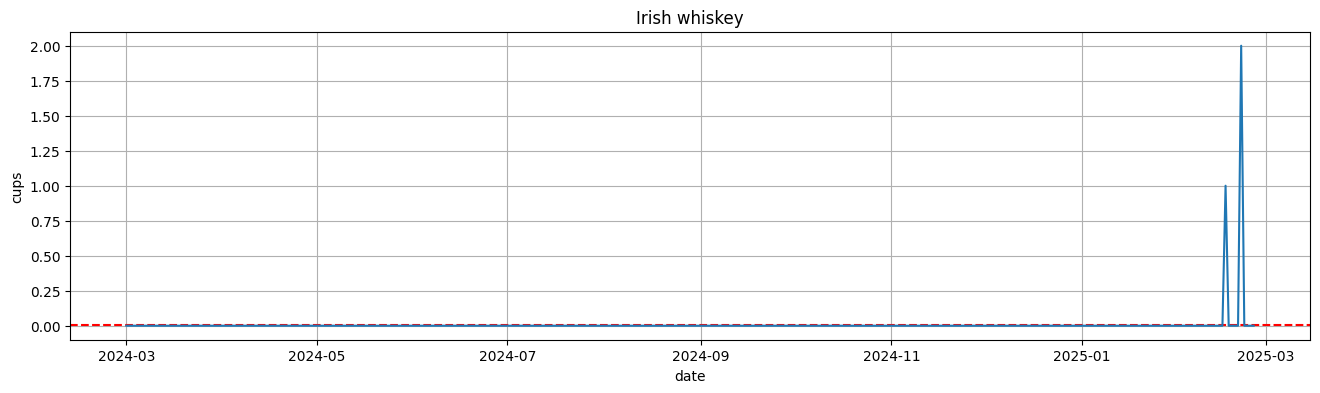

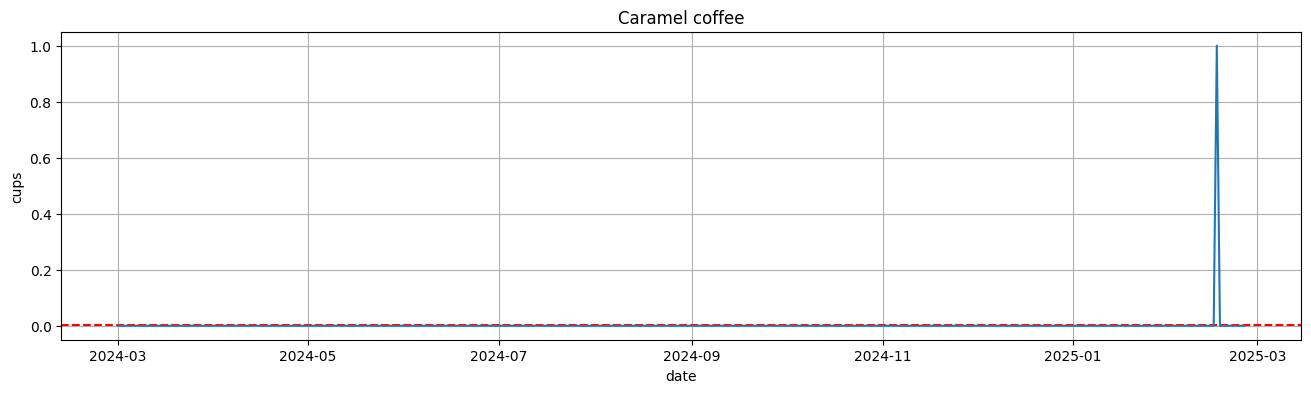

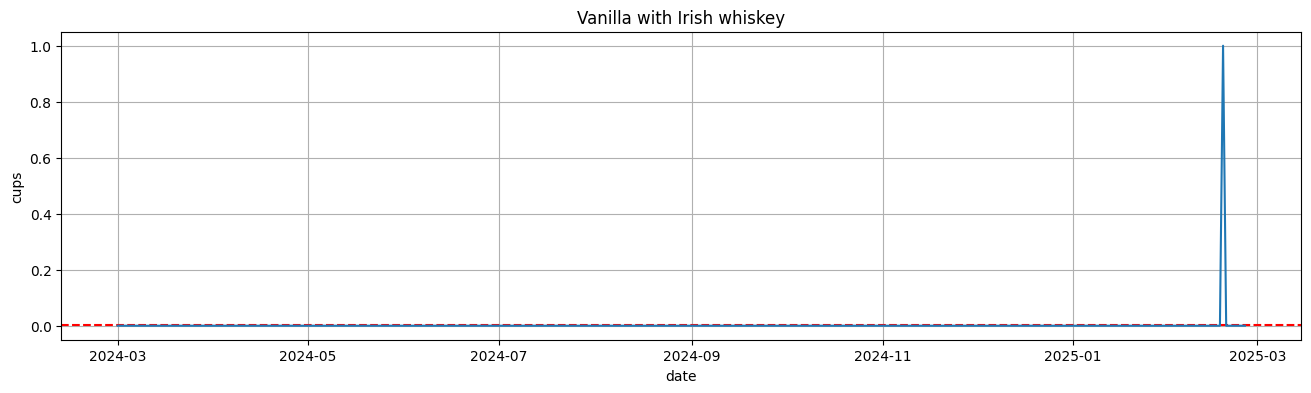

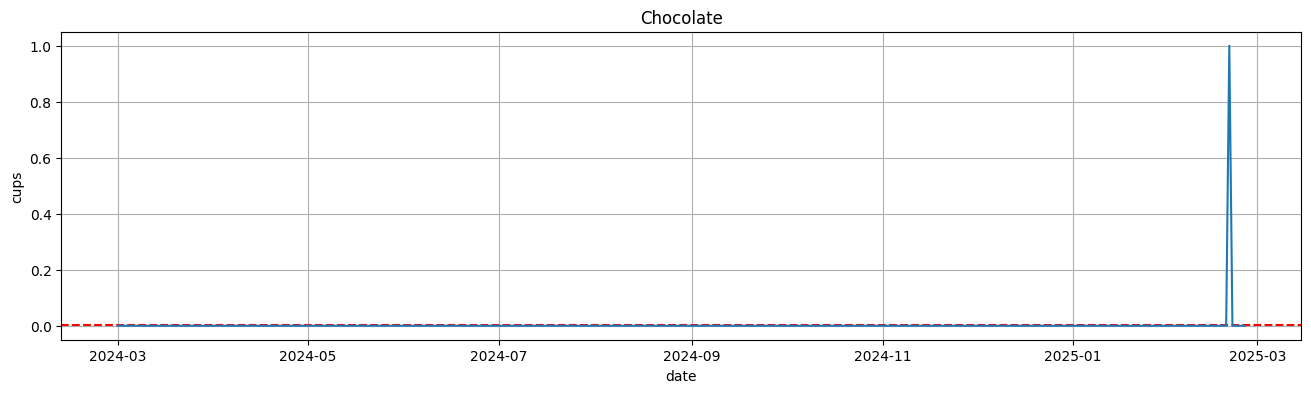

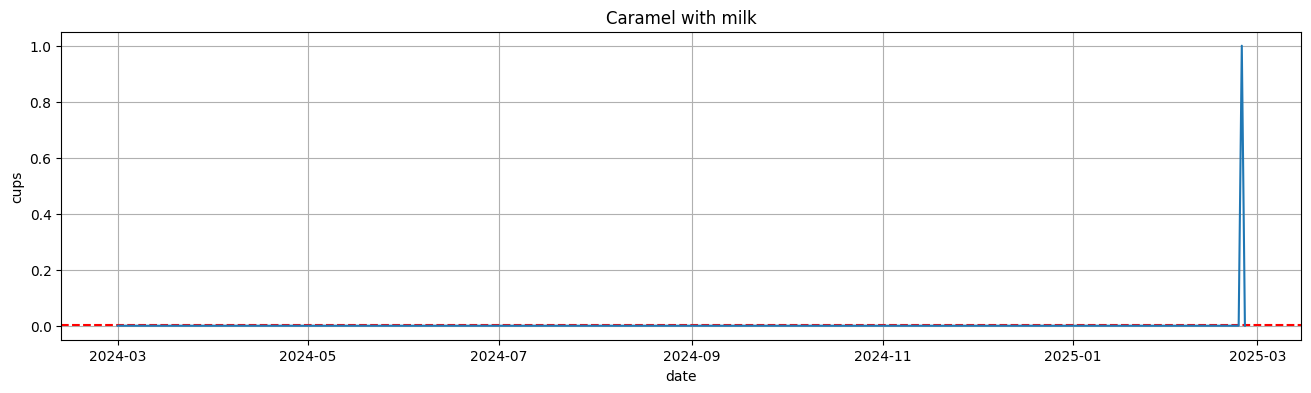

In [ ]:
date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())
coffee_names = df["coffee_name"].unique()
pairs = list(itertools.product(date_range, coffee_names))
pairs_df = pd.DataFrame(pairs, columns=["date", "coffee_name"])

df_by_date_coffe = df.groupby(["date", "coffee_name"]).agg({"money" : ["sum", "count"]}).reset_index()
df_by_date_coffe.columns = ["date", "coffee_name", "money", "cups"]


complete_df = pd.merge(pairs_df, df_by_date_coffe, on=["date", "coffee_name"], how="left")
complete_df.fillna(0, inplace=True)
complete_df.sort_values(by="cups", ascending=False, inplace=True)

for name in coffee_names:
  data = complete_df[complete_df["coffee_name"] == name]
  plt.figure(figsize=(16,4))
  avg_cups = data["cups"].mean()
  plt.axhline(avg_cups, color="red", linestyle="--")
  sns.lineplot(data=data, y="cups", x="date")
  plt.title(name)
  plt.grid()
  plt.show()

In [ ]:
temp = df[["datetime", "money"]].copy()
temp.index = np.array(df["datetime"], dtype=np.datetime64)
temp = temp[["money"]]
temp.head(3)

,money
2024-03-01 10:15:50.520,38.7
2024-03-01 12:19:22.539,38.7
2024-03-01 12:20:18.089,38.7


Daily Coffee Sales (Sum) Decomposition


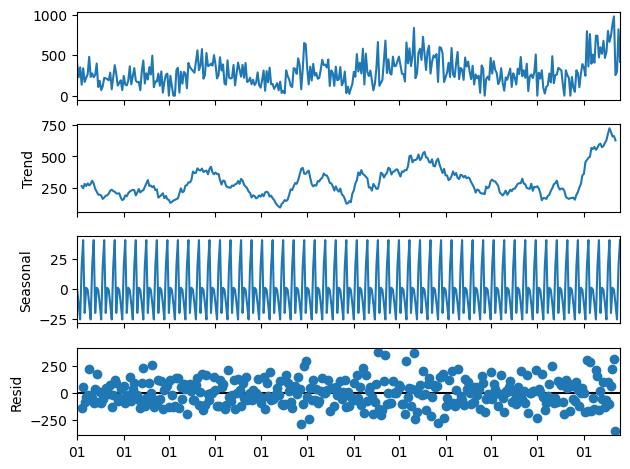

In [ ]:
print('Daily Coffee Sales (Sum) Decomposition')
print('======================================')
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

Daily Coffee Sales (Avg) Decomposition


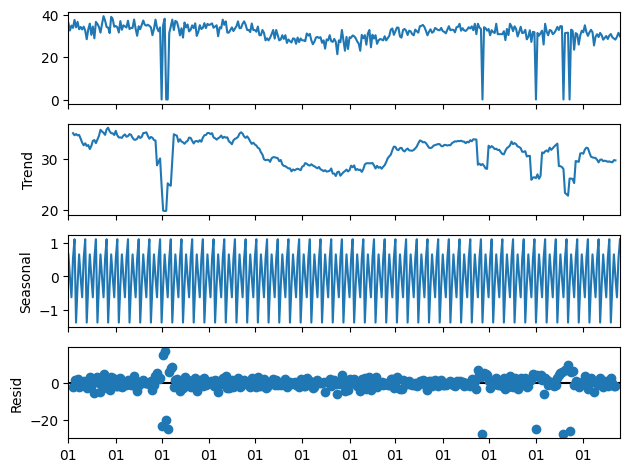

In [ ]:
print('Daily Coffee Sales (Avg) Decomposition')
print('======================================')
daily_data = temp.resample('D').mean()
daily_data = daily_data.dropna().asfreq('D', fill_value=0)
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

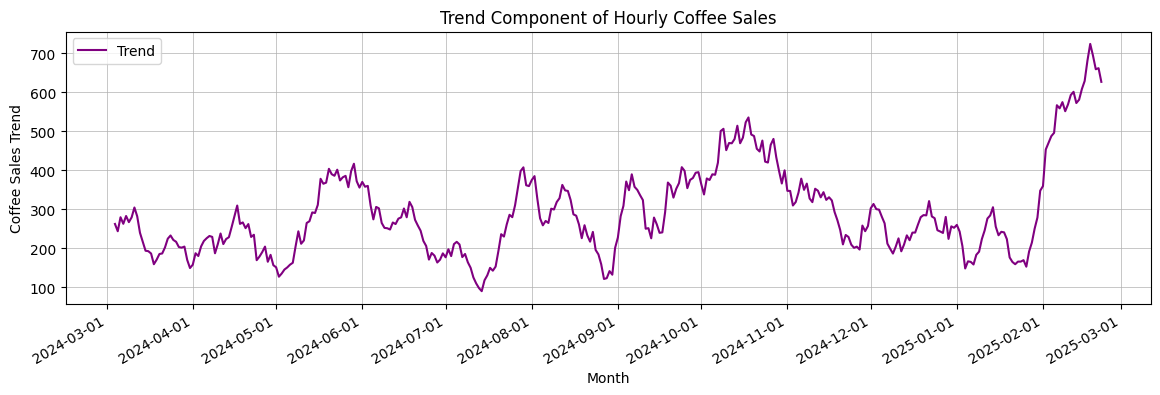

The slope of the trend component is: 0.441710448509203


In [ ]:
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
trend = result.trend.dropna()

plt.figure(figsize=(14, 4))
plt.plot(trend.index, trend, label='Trend', color='purple')
plt.xlabel('Month')
plt.ylabel('Coffee Sales Trend')
plt.title('Trend Component of Hourly Coffee Sales')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True, which='major', linestyle='-', linewidth='0.5')
plt.gcf().autofmt_xdate()

plt.show()

trend_slope, intercept = np.polyfit(range(len(trend)), trend, deg=1)
print(f"The slope of the trend component is: {trend_slope}")

In [ ]:
def interpret_adfuller_test(pvalue, sig_level):
  if pvalue < sig_level:
    return "REJECT H_0: The time series is stationary!"
  return "Cannot reject H_0: The time series is not stationary!"

In [ ]:
significant_level = 0.05

result = adfuller(df['money'])
print(f'ADF Statictic: {result[0]}')
print(f'P-value: {result[1]}')
print('-'*50)
print(interpret_adfuller_test(result[1], significant_level))

ADF Statictic: -3.8706111340370666
P-value: 0.0022621002449582745
--------------------------------------------------
REJECT H_0: The time series is stationary!


#### Preprocess Data

In [ ]:
daily_sales = df.groupby("date")['money'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)
print(f"Number of days: {daily_sales.shape[0]}")
daily_sales.head(3)

Number of days: 362


,money
date,
2024-03-01,396.3
2024-03-02,228.1
2024-03-03,349.1


Remove seasonal pattern (weekly pattern)

In [ ]:
seasonal_diff = daily_sales.diff(7).dropna()
seasonal_diff.head(10)

,money
date,
2024-03-08,-130.8
2024-03-09,251.3
2024-03-10,-117.5
2024-03-11,140.0
2024-03-12,-110.4
2024-03-13,86.0
2024-03-14,177.0
2024-03-15,-157.9
2024-03-16,-296.2


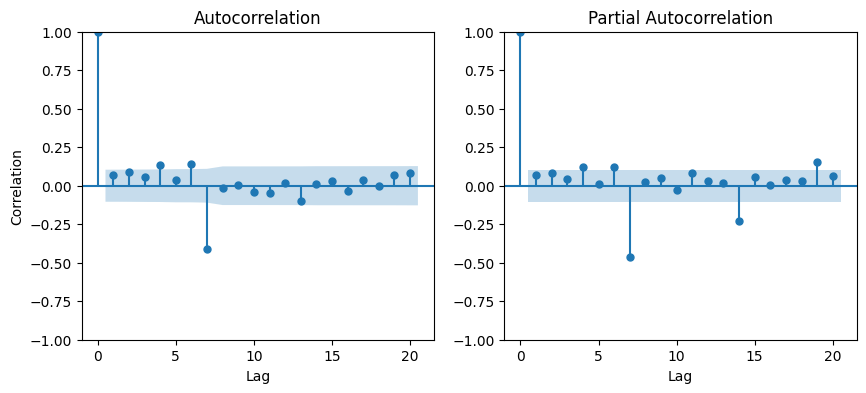

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(seasonal_diff, lags=20, ax=axes[0])
plot_pacf(seasonal_diff, lags=20, ax=axes[1])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[1].set_xlabel('Lag')
plt.show()

In [ ]:
# Seasonal Parameters

P = 1 # p = AR term
Q = 1 # q = MA term
D = 1 # since seasonal differencing has been performed
s = 7 # since weekly seasonality has been observed

# NO-seasonal Parameters

p_AR_term = 1
q_MA_term = 1
d_differencing_term = 1

In [ ]:
model = SARIMAX(
    daily_sales,
    order=(p_AR_term, d_differencing_term, q_MA_term),
    seasonal_order=(P, D, Q, s)
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             money   No. Observations:                  362
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2272.652
Date:                           Sun, 16 Mar 2025   AIC                           4555.305
Time:                                   12:03:47   BIC                           4574.651
Sample:                               03-01-2024   HQIC                          4563.002
                                    - 02-25-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0798      0.057     -1.401      0.161      -0.191       0.032
ma.L1         -0.7764      0.034    -22.617